In [1]:
!nvidia-smi

Fri Aug 25 14:56:39 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   66C    P8    11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!pip install -q numpy
!pip install -q matplotlib
!pip install -q pandas
!pip install -q tensorflow
!pip install -q scikit-learn
!pip install -q pandas-datareader
!pip install -q yfinance
!pip install --upgrade mplfinance

# Code Source Note: https://github.com/twopirllc/pandas-ta
!pip install -q pandas_ta

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 2.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [3]:
import os
import sys
from google.colab import drive
drive.mount('/content/drive/')

# Set the working directory for the tasks
SKELETON_DIR = '/content/drive/MyDrive/stock-prediction/DataProcessing2'
os.chdir(SKELETON_DIR)

Mounted at /content/drive/


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pandas_ta as ta
import pandas_datareader as web
import datetime as dt
import tensorflow as tf
import yfinance as yf
import mplfinance as mpf

from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, Dropout, LSTM, InputLayer, Input, Activation
from tensorflow.keras.utils import plot_model


In [5]:
start='2015-01-01'
end='2023-08-25'
ticker='TSLA'

# Price Value
price_value = 'Close' # This can be change to 'Open', 'Close', 'Adj Close , 'High', 'Low'

# Split Dataset for Training/Testing
split_ratio=0.8

# Number of look back days to base the prediction
step_size = 30 # Can be changed

# Directory
DATA_DIR = os.path.join(SKELETON_DIR, "data")
PREPARED_DATA_DIR = os.path.join(SKELETON_DIR, "prepared-data")

# File Path
CSV_FILE = os.path.join(DATA_DIR, f"RawData-from-{start}to-{end}-{ticker}_stock_data.csv")
PREPARED_DATA_FILE = os.path.join(PREPARED_DATA_DIR, f"PreparedData-from-{start}to-{end}-{ticker}_stock_data.csv")
PREPARED_TRAIN = os.path.join(PREPARED_DATA_DIR, f"{ticker}_prepared_data.npz")


In [6]:
# Double check directory
def ensure_directory_exists(dir_path):
  # If directory not exist => create
  if not os.path.isdir(dir_path):
      os.mkdir(dir_path)

In [7]:
# Load Raw Data
def load_data(start, end, ticker, source='yahoo'):
  ensure_directory_exists(DATA_DIR)

  # Check if CSV file exists
  # If exist => load
  # If not exist => download
  if os.path.exists(CSV_FILE):
      print('Loading Existing Data')
      data = pd.read_csv(CSV_FILE)
  else:
      print('Downloading Data')
      data = yf.download(ticker, start, end, progress=False)
      data.to_csv(CSV_FILE)

  return data

In [8]:
# Data Validation
def data_validation(start, end, ticker):
  ensure_directory_exists(PREPARED_DATA_DIR)


  if os.path.exists(PREPARED_DATA_FILE):
      print('Loading Prepared Data')
      df = pd.read_csv(PREPARED_DATA_FILE)
  else:
      print('Processing Raw Data')

      # Read Raw Data File
      df = pd.read_csv(CSV_FILE)

      df['Date'] = pd.to_datetime(df['Date'])

      df.set_index('Date', inplace=True)

      # Adding indicators
      df['RSI']=ta.rsi(df.Close, length=15)
      df['EMAF']=ta.ema(df.Close, length=20)
      df['EMAM']=ta.ema(df.Close, length=100)
      df['EMAS']=ta.ema(df.Close, length=150)

      df['Target'] = df['Adj Close']-df.Open
      df['Target'] = df['Target'].shift(-1)

      df['TargetClass'] = [1 if df.Target[i]>0 else 0 for i in range(len(df))]

      df['TargetNextClose'] = df['Adj Close'].shift(-1)

      # Drop NaN issue in data
      df.dropna(inplace=True)

      # Drop Columns
      # df.drop(['Volume','Close', 'Date'], axis=1, inplace=True)

      # Export Prepared Data
      df.to_csv(PREPARED_DATA_FILE, index=False)

  return df

In [9]:
# Split Data by Date or Randomly
def split_data(df, split_ratio, split_by_date=True):
    if split_by_date:
        # Split by date
        train_size = int(len(df) * split_ratio)
        train_data = df.iloc[:train_size]
        test_data = df.iloc[train_size:]
    else:
        # Split Randomly
        train_data, test_data = train_test_split(df, test_size=1-split_ratio, random_state=42)

    print(f"Train Data Shape: {train_data.shape}")
    print(f"Test Data Shape: {test_data.shape}")

    return train_data, test_data


In [10]:
# Scaler
def scaler_features(input_data, scale=True):
    if scale:
        scaler = MinMaxScaler(feature_range=(0, 1))

        # Reshaping if input_data is a Series or 1D numpy array
        if len(input_data.shape) == 1:
            input_data = input_data.values.reshape(-1, 1)

        scaled_data = scaler.fit_transform(input_data)
        return scaled_data, scaler
    else:
        return input_data, None


In [11]:
def create_datasets(start, end, ticker):
    # Download or Load Raw Data
    data = load_data(start, end, ticker)

    # Data Validation
    df = data_validation(start, end, ticker)

    # Split Data
    train_data, test_data = split_data(df, split_ratio)

    # Define features and target
    feature_columns = ['Open', 'High', 'Low', 'RSI', 'EMAF', 'EMAM', 'EMAS']
    target_column = 'TargetNextClose'

    # Preparing Train Datasets
    # Scaler for features
    scaled_data_train, train_feature_scaler = scaler_features(train_data[feature_columns])
    # Scaler for target
    scaled_target_train, train_target_scaler = scaler_features(train_data[target_column].values.reshape(-1, 1))

    x_train, y_train = [], []
    for i in range(step_size, len(scaled_data_train)):
        x_train.append(scaled_data_train[i-step_size:i])
        y_train.append(scaled_target_train[i])

    x_train, y_train = np.array(x_train), np.array(y_train)

    # Preparing Test Datasets
    # Use the feature scaler to scale the test data
    scaled_data_test = train_feature_scaler.transform(test_data[feature_columns])
    # Use the target scaler to scale the test target
    scaled_target_test = train_target_scaler.transform(test_data[target_column].values.reshape(-1, 1))

    x_test, y_test = [], []
    for i in range(step_size, len(scaled_data_test)):
        x_test.append(scaled_data_test[i-step_size:i])
        y_test.append(scaled_target_test[i])

    x_test, y_test = np.array(x_test), np.array(y_test)

    np.savez(PREPARED_TRAIN, x_train=x_train, y_train=y_train)

    return data, df, train_data, test_data, train_feature_scaler, train_target_scaler, x_train, x_test, y_train, y_test


In [43]:
data, df, train_data, test_data, train_feature_scaler, train_target_scaler, x_train, x_test, y_train, y_test = create_datasets(start, end, ticker)

Loading Existing Data
Loading Prepared Data
Train Data Shape: (1620, 13)
Test Data Shape: (406, 13)


In [13]:
print("Data shapes/types:")
print("data:", type(data))
print("df:", type(df))
print("train_data:", train_data.shape)
print("test_data:", test_data.shape)
print("train_feature_scaler:", type(train_feature_scaler))
print("train_target_scaler:", type(train_target_scaler))
print("x_train:", x_train.shape)
print("x_test:", x_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

Data shapes/types:
data: <class 'pandas.core.frame.DataFrame'>
df: <class 'pandas.core.frame.DataFrame'>
train_data: (1620, 13)
test_data: (406, 13)
train_feature_scaler: <class 'sklearn.preprocessing._data.MinMaxScaler'>
train_target_scaler: <class 'sklearn.preprocessing._data.MinMaxScaler'>
x_train: (1590, 30, 7)
x_test: (376, 30, 7)
y_train: (1590, 1)
y_test: (376, 1)


In [14]:
data.head(3)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-01-02,14.858000,14.883333,14.217333,14.620667,14.620667,71466000
2015-01-05,14.303333,14.433333,13.810667,14.006000,14.006000,80527500
2015-01-06,14.004000,14.280000,13.614000,14.085333,14.085333,93928500


In [15]:
data.tail(3)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-08-22,240.250000,240.820007,229.550003,233.190002,233.190002,130597900
2023-08-23,229.339996,238.979996,229.289993,236.860001,236.860001,101077600
2023-08-24,238.660004,238.919998,228.179993,230.039993,230.039993,99519300


In [16]:
df.head(3)

,Open,High,Low,Close,Adj Close,Volume,RSI,EMAF,EMAM,EMAS,Target,TargetClass,TargetNextClose
Date,,,,,,,,,,,,,
2015-08-06,16.636000,17.000000,15.741333,16.408667,16.408667,219357000,40.237745,17.562829,16.245100,15.200760,-0.071333,0,16.167334
2015-08-07,16.238667,16.248667,15.892667,16.167334,16.167334,76101000,38.598500,17.429924,16.243561,15.213562,0.199333,1,16.076000
2015-08-10,15.876667,16.198000,15.736667,16.076000,16.076000,62788500,37.971249,17.300979,16.240243,15.224985,0.014667,1,15.824667


In [17]:
df.tail(3)

,Open,High,Low,Close,Adj Close,Volume,RSI,EMAF,EMAM,EMAS,Target,TargetClass,TargetNextClose
Date,,,,,,,,,,,,,
2023-08-21,221.550003,232.130005,220.580002,231.279999,231.279999,135702700,41.132038,243.068776,230.590960,223.752151,-7.059998,0,233.190002
2023-08-22,240.250000,240.820007,229.550003,233.190002,233.190002,130597900,42.417038,242.127941,230.642426,223.877156,7.520004,1,236.860001
2023-08-23,229.339996,238.979996,229.289993,236.860001,236.860001,101077600,44.893445,241.626232,230.765546,224.049114,-8.620010,0,230.039993


In [18]:
train_data.head(3)

,Open,High,Low,Close,Adj Close,Volume,RSI,EMAF,EMAM,EMAS,Target,TargetClass,TargetNextClose
Date,,,,,,,,,,,,,
2015-08-06,16.636000,17.000000,15.741333,16.408667,16.408667,219357000,40.237745,17.562829,16.245100,15.200760,-0.071333,0,16.167334
2015-08-07,16.238667,16.248667,15.892667,16.167334,16.167334,76101000,38.598500,17.429924,16.243561,15.213562,0.199333,1,16.076000
2015-08-10,15.876667,16.198000,15.736667,16.076000,16.076000,62788500,37.971249,17.300979,16.240243,15.224985,0.014667,1,15.824667


In [19]:
train_data.tail(3)

,Open,High,Low,Close,Adj Close,Volume,RSI,EMAF,EMAM,EMAS,Target,TargetClass,TargetNextClose
Date,,,,,,,,,,,,,
2022-01-06,359.000000,362.666656,340.166656,354.899994,354.899994,90336600,51.079304,354.262754,316.084408,295.390988,-17.803314,0,342.320007
2022-01-07,360.123322,360.309998,336.666656,342.320007,342.320007,84164700,47.672453,353.125350,316.603925,296.012565,19.373322,1,352.706665
2022-01-10,333.333344,353.033325,326.666656,352.706665,352.706665,91815000,50.587870,353.085475,317.318831,296.763480,3.576660,1,354.799988


In [20]:
test_data.head(3)

,Open,High,Low,Close,Adj Close,Volume,RSI,EMAF,EMAM,EMAS,Target,TargetClass,TargetNextClose
Date,,,,,,,,,,,,,
2022-01-11,351.223328,358.616669,346.273346,354.799988,354.799988,66063300,51.175269,353.248762,318.061032,297.532176,9.123322,1,368.739990
2022-01-12,359.616669,371.613342,357.529999,368.739990,368.739990,83739000,54.992715,354.724117,319.064576,298.475325,-25.836670,0,343.853333
2022-01-13,369.690002,371.866669,342.179993,343.853333,343.853333,97209900,47.838278,353.688804,319.555442,299.076359,9.910004,1,349.869995


In [21]:
test_data.tail(3)

,Open,High,Low,Close,Adj Close,Volume,RSI,EMAF,EMAM,EMAS,Target,TargetClass,TargetNextClose
Date,,,,,,,,,,,,,
2023-08-21,221.550003,232.130005,220.580002,231.279999,231.279999,135702700,41.132038,243.068776,230.590960,223.752151,-7.059998,0,233.190002
2023-08-22,240.250000,240.820007,229.550003,233.190002,233.190002,130597900,42.417038,242.127941,230.642426,223.877156,7.520004,1,236.860001
2023-08-23,229.339996,238.979996,229.289993,236.860001,236.860001,101077600,44.893445,241.626232,230.765546,224.049114,-8.620010,0,230.039993


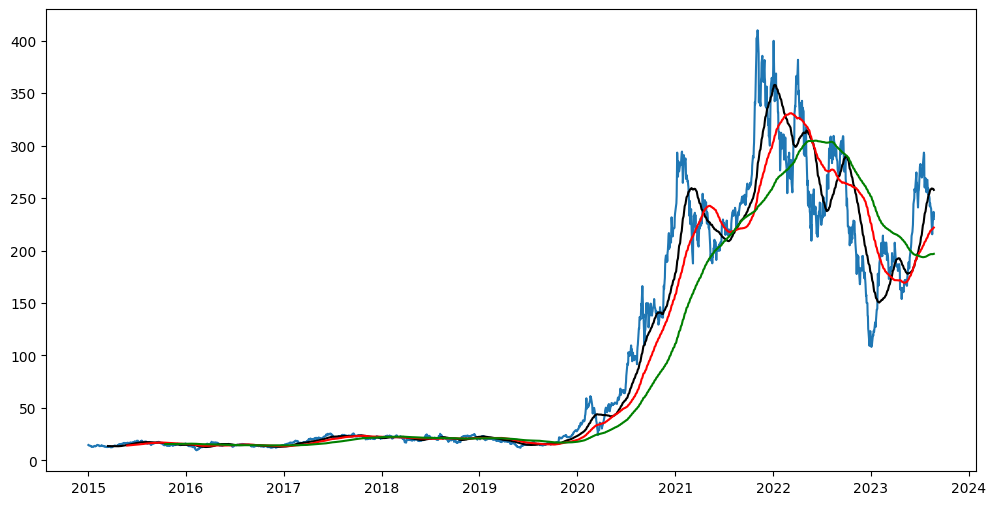

In [22]:
# Moving Avg
ma50 = data[price_value].rolling(50).mean()
ma100 = data[price_value].rolling(100).mean()
ma200 = data[price_value].rolling(200).mean()

# Plot Chart with MA
plt.figure(figsize=(12,6))
plt.plot(data.Close)
plt.plot(ma50, 'k')
plt.plot(ma100,'r')
plt.plot(ma200,'g')

In [23]:
def plot_candlestick_normal(input_df):

  input_df = input_df.copy()

  # Set the "Date" column as the index
  # input_df.set_index('Date', inplace=True)
  # input_df.index = pd.to_datetime(input_df.index)

  # Add moving averages to the dataframe
  input_df['MA50'] = input_df[price_value].rolling(window=50).mean()
  input_df['MA100'] = input_df[price_value].rolling(window=100).mean()
  input_df['MA200'] = input_df[price_value].rolling(window=200).mean()

  # Set the "Date" column as the index
  # input_df.set_index('Date', inplace=True)

  # Convert the index to a DatetimeIndex
  # input_df.index = pd.to_datetime(input_df.index)

  # Plot the last 200 days (or adjust if needed)
  df_plot = input_df.copy() #input_df[-200:].copy()

  # Create a custom plot for the predicted prices
  ap = [mpf.make_addplot(df_plot['MA50'], color='orange'),
        mpf.make_addplot(df_plot['MA100'], color='green'),
        mpf.make_addplot(df_plot['MA200'], color='magenta')]

  # Plot the candlestick chart
  mpf.plot(df_plot, type='candle', style='charles',
          title=f"{ticker} Candlestick Chart",
          ylabel='Price',
          volume=False,
          addplot=ap,
          show_nontrading=False)

/usr/local/lib/python3.10/dist-packages/mplfinance/_arg_validators.py:84: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


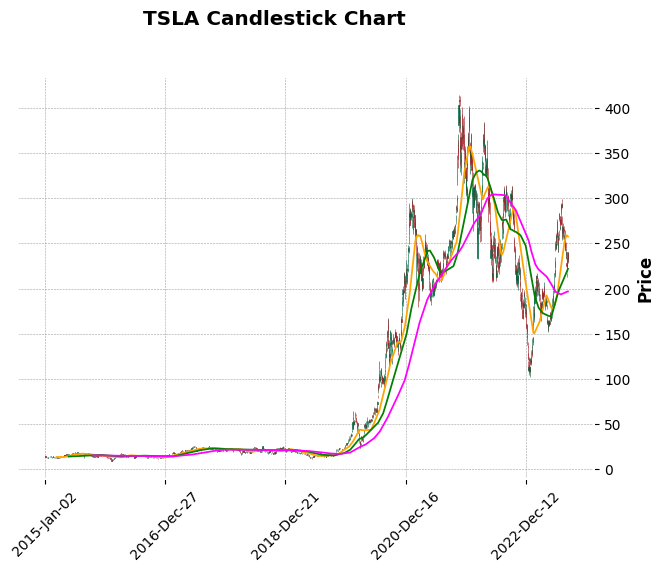

In [24]:
plot_candlestick_normal(data)

/usr/local/lib/python3.10/dist-packages/mplfinance/_arg_validators.py:84: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


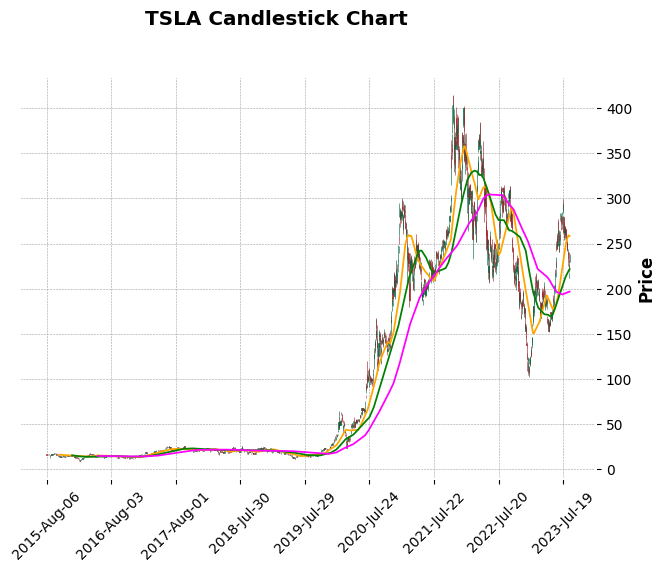

In [25]:
plot_candlestick_normal(df)

/usr/local/lib/python3.10/dist-packages/mplfinance/_arg_validators.py:84: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


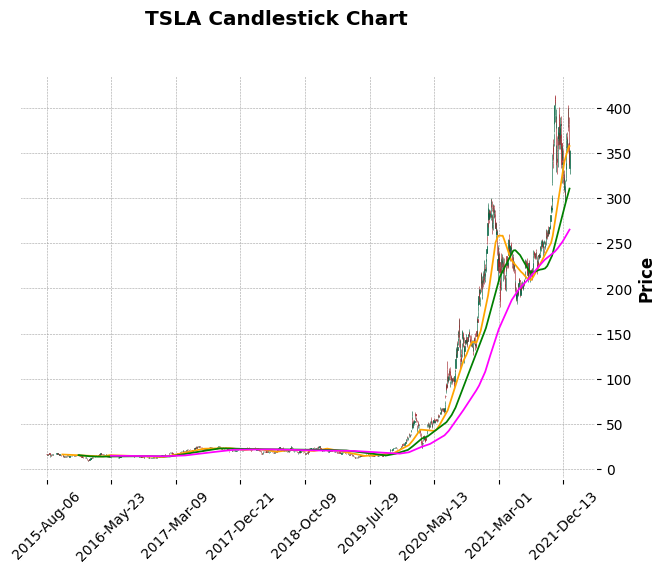

In [26]:
plot_candlestick_normal(train_data)

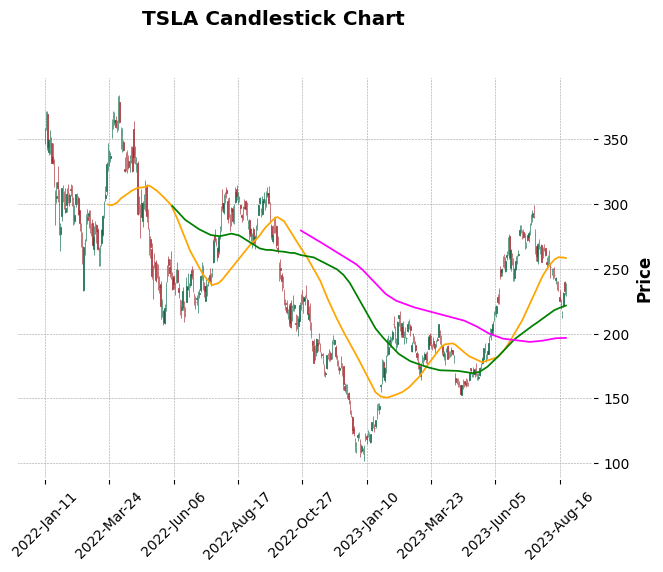

In [27]:
plot_candlestick_normal(test_data)

In [28]:
def create_model(input_x_train):
    model = Sequential()

    # First LSTM layer with Dropout
    model.add(LSTM(units=120, return_sequences=True, input_shape=(input_x_train.shape[1], input_x_train.shape[2])))
    model.add(Dropout(0.25))

    # Second LSTM layer with Dropout
    model.add(LSTM(units=100, return_sequences=True))
    model.add(Dropout(0.25))

    # Third LSTM layer with Dropout
    model.add(LSTM(units=80, return_sequences=True))
    model.add(Dropout(0.25))

    # Fourth LSTM layer with Dropout
    model.add(LSTM(units=60, return_sequences=True))
    model.add(Dropout(0.25))

    # Fifth LSTM layer with Dropout
    model.add(LSTM(units=40))
    model.add(Dropout(0.25))

    # Dense layer to produce the output
    model.add(Dense(units=1))

    return model

In [29]:
def plot_metric(metric_name_1, metric_name_2, plot_name):
  # Get Metric values using metric names as identifiers
  metric_value_1 = model_training_history.history[metric_name_1]
  metric_value_2 = model_training_history.history[metric_name_2]

  # Constructing a range object which will be used as time
  epochs = range(len(metric_value_1))

  # Plotting the Graph
  plt.plot(epochs, metric_value_1, 'blue', label = metric_name_1)
  plt.plot(epochs, metric_value_2, 'red', label = metric_name_2)

  # Adding title to the plot
  plt.title(str(plot_name))

  # Adding legend to the plot
  plt.legend()

In [30]:
# Create model
model = create_model(x_train)

# Summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 120)           61440     
                                                                 
 dropout (Dropout)           (None, 30, 120)           0         
                                                                 
 lstm_1 (LSTM)               (None, 30, 100)           88400     
                                                                 
 dropout_1 (Dropout)         (None, 30, 100)           0         
                                                                 
 lstm_2 (LSTM)               (None, 30, 80)            57920     
                                                                 
 dropout_2 (Dropout)         (None, 30, 80)            0         
                                                                 
 lstm_3 (LSTM)               (None, 30, 60)            3

In [31]:
# Training
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 15, mode = 'min', restore_best_weights = True)
model.compile(loss = 'mse', optimizer = 'adam', metrics = ["accuracy"])
model_training_history = model.fit(x_train, y_train, batch_size=32, epochs=500, shuffle=True, validation_split = 0.2, callbacks = [early_stopping_callback])

Epoch 1/500
40/40 [==============================] - 24s 59ms/step - loss: 0.0015 - accuracy: 7.8616e-04 - val_loss: 0.0181 - val_accuracy: 0.0031
Epoch 2/500
40/40 [==============================] - 1s 16ms/step - loss: 5.3293e-04 - accuracy: 7.8616e-04 - val_loss: 0.0197 - val_accuracy: 0.0031
Epoch 3/500
40/40 [==============================] - 1s 15ms/step - loss: 3.5445e-04 - accuracy: 7.8616e-04 - val_loss: 0.0142 - val_accuracy: 0.0031
Epoch 4/500
40/40 [==============================] - 1s 15ms/step - loss: 5.2174e-04 - accuracy: 7.8616e-04 - val_loss: 0.0296 - val_accuracy: 0.0031
Epoch 5/500
40/40 [==============================] - 1s 15ms/step - loss: 6.0040e-04 - accuracy: 7.8616e-04 - val_loss: 0.0128 - val_accuracy: 0.0031
Epoch 6/500
40/40 [==============================] - 1s 15ms/step - loss: 3.7223e-04 - accuracy: 7.8616e-04 - val_loss: 0.0363 - val_accuracy: 0.0000e+00
Epoch 7/500
40/40 [==============================] - 1s 15ms/step - loss: 3.8421e-04 - accuracy: 7.

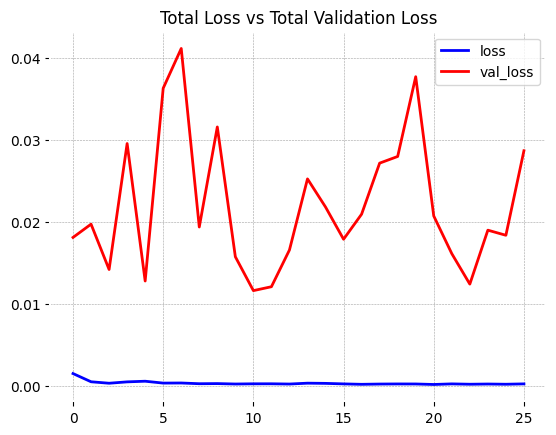

In [32]:
# Plot Total Loss vs Total Validation Loss
plot_metric('loss', 'val_loss', 'Total Loss vs Total Validation Loss')

In [44]:
# Model coded added before for testing, won't be available in this submission.
predicted_prices = model.predict(x_test)
predicted_prices = train_target_scaler.inverse_transform(predicted_prices)

12/12 [==============================] - 0s 7ms/step


In [45]:
print(predicted_prices)

[[277.31964]
 [277.05643]
 [276.7263 ]
 [276.34473]
 [275.95163]
 [275.56104]
 [275.19797]
 [274.87552]
 [274.59448]
 [274.35648]
 [274.13773]
 [273.93564]
 [273.75522]
 [273.5891 ]
 [273.39722]
 [273.1835 ]
 [272.96964]
 [272.78   ]
 [272.64056]
 [272.57767]
 [272.62714]
 [272.79642]
 [273.09448]
 [273.5217 ]
 [274.075  ]
 [274.72916]
 [275.46362]
 [276.25146]
 [277.07327]
 [277.9045 ]
 [278.70978]
 [279.47375]
 [280.14447]
 [280.70868]
 [281.15347]
 [281.4883 ]
 [281.71887]
 [281.86575]
 [281.94287]
 [281.97656]
 [281.977  ]
 [281.96524]
 [281.95087]
 [281.9318 ]
 [281.8832 ]
 [281.77954]
 [281.6117 ]
 [281.37698]
 [281.0855 ]
 [280.75958]
 [280.4124 ]
 [280.05945]
 [279.6942 ]
 [279.2965 ]
 [278.8558 ]
 [278.35724]
 [277.79596]
 [277.17636]
 [276.50388]
 [275.78854]
 [275.05505]
 [274.29633]
 [273.50906]
 [272.69147]
 [271.83173]
 [270.94592]
 [270.0624 ]
 [269.22488]
 [268.46167]
 [267.79706]
 [267.22824]
 [266.7633 ]
 [266.37738]
 [266.04672]
 [265.7762 ]
 [265.53528]
 [265.28796]

In [35]:
print(type(train_data))
print(type(test_data))
print(type(predicted_prices))

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'numpy.ndarray'>


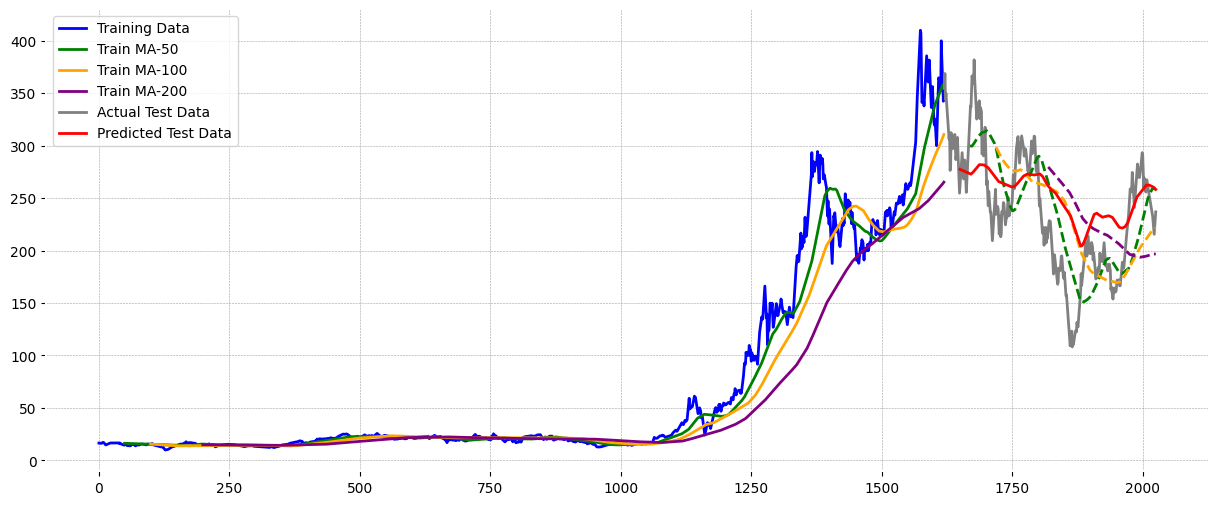

In [47]:
# Convert numpy arrays to pandas DataFrame for easy rolling computation
train_df = pd.DataFrame(train_data)
test_df = pd.DataFrame(test_data)

# Compute moving averages for training data
train_ma50 = train_df[price_value].rolling(50).mean()
train_ma100 = train_df[price_value].rolling(100).mean()
train_ma200 = train_df[price_value].rolling(200).mean()

# Compute moving averages for test data
test_ma50 = test_df[price_value].rolling(50).mean()
test_ma100 = test_df[price_value].rolling(100).mean()
test_ma200 = test_df[price_value].rolling(200).mean()

# Plotting
plt.figure(figsize=(15, 6))

# Plot training data and its moving averages
plt.plot(train_df[price_value], color='blue', label='Training Data')
plt.plot(train_ma50, color='green', label='Train MA-50')
plt.plot(train_ma100, color='orange', label='Train MA-100')
plt.plot(train_ma200, color='purple', label='Train MA-200')

# Plot test data, its moving averages, and predicted prices
test_data_start = len(train_df) #+ 149

plt.plot(range(test_data_start, test_data_start + len(test_df[price_value])), test_df[price_value], color='gray', label='Actual Test Data')
plt.plot(range(test_data_start, test_data_start + len(test_df[price_value])), test_ma50.values, color='green', linestyle='dashed')
plt.plot(range(test_data_start, test_data_start + len(test_df[price_value])), test_ma100.values, color='orange', linestyle='dashed')
plt.plot(range(test_data_start, test_data_start + len(test_df[price_value])), test_ma200.values, color='purple', linestyle='dashed')

predicted_data_range = range(test_data_start + step_size, test_data_start + len(predicted_prices) + step_size)
plt.plot(predicted_data_range, predicted_prices, color='red', label='Predicted Test Data')

plt.legend()
plt.show()


In [37]:
def plot_candlestick_predicted(input_df, predicted_prices):
    # Work with a deep copy to avoid modifying the original dataframe
    input_df = input_df.copy()

    # Set the "Date" column as the index
    # input_df.set_index('Date', inplace=True)
    # input_df.index = pd.to_datetime(input_df.index)

    # Add moving averages to the dataframe
    input_df['MA50'] = input_df[price_value].rolling(window=50).mean()
    input_df['MA100'] = input_df[price_value].rolling(window=100).mean()
    input_df['MA200'] = input_df[price_value].rolling(window=200).mean()

    # Convert the index to a DatetimeIndex
    input_df.index = pd.to_datetime(input_df.index)

    # Plot the last the last predicted candles
    df_plot = input_df[-len(predicted_prices):].copy()

    # Add Predicted Prices
    # Check if predicted_prices is 2D and reshape if necessary
    if predicted_prices.ndim == 2:
        predicted_prices = predicted_prices.reshape(-1)

    # Ensure the length of predicted_prices
    # matches the length of the sliced portion of the DataFrame
    if len(predicted_prices) > len(df_plot):
        predicted_prices = predicted_prices[-len(df_plot):]  # Take only the last predictions
    elif len(predicted_prices) < len(df_plot):
        print(f"Length mismatch: predicted_prices has length {len(predicted_prices)} but df_plot has length {len(df_plot)}")
        # Align the predictions to the end of df_plot
        start_idx = len(df_plot) - len(predicted_prices)
        df_plot = df_plot[start_idx:].copy()

    df_plot['Predicted'] = predicted_prices

    # Create a custom plot for the predicted prices
    ap = [mpf.make_addplot(df_plot['MA50'], color='orange'),
          mpf.make_addplot(df_plot['MA100'], color='green'),
          mpf.make_addplot(df_plot['MA200'], color='magenta'),
          mpf.make_addplot(df_plot['Predicted'], color='red', linestyle='dashed')]

    # Plot the candlestick chart
    mpf.plot(df_plot, type='candle', style='charles',
             title=f"{ticker}Candlestick Chart",
             ylabel='Price',
             volume=False,
             addplot=ap,
             show_nontrading=False)

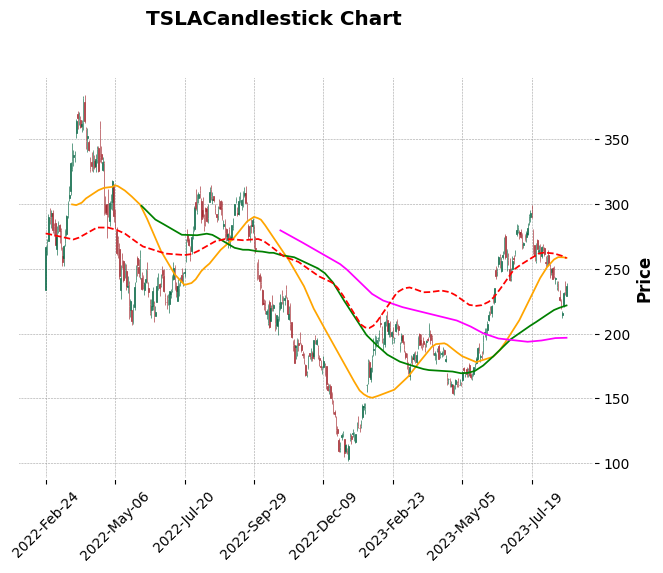

In [38]:
plot_candlestick_predicted(test_data, predicted_prices)

In [39]:
def plot_candlestick_full(train_df, test_df, predicted_prices):
    # Create deep copies to avoid modifying the original dataframes
    train_df = train_df.copy()
    test_df = test_df.copy()

    # Set the "Date" column as the index
    # train_df.set_index('Date', inplace=True)
    # train_df.index = pd.to_datetime(train_df.index)
    # test_df.set_index('Date', inplace=True)
    # test_df.index = pd.to_datetime(test_df.index)

    # Compute moving averages for the training data
    train_df['MA50'] = train_df[price_value].rolling(window=50).mean()
    train_df['MA100'] = train_df[price_value].rolling(window=100).mean()
    train_df['MA200'] = train_df[price_value].rolling(window=200).mean()

    # Compute moving averages for the test data
    test_df['MA50'] = test_df[price_value].rolling(window=50).mean()
    test_df['MA100'] = test_df[price_value].rolling(window=100).mean()
    test_df['MA200'] = test_df[price_value].rolling(window=200).mean()

    # Check if predicted_prices is 2D and reshape if necessary
    if predicted_prices.ndim == 2:
        predicted_prices = predicted_prices.reshape(-1)

    # Ensure the length of predicted_prices matches the length of the test data
    if len(predicted_prices) != len(test_df):
        raise ValueError(f"Length mismatch: predicted_prices has length {len(predicted_prices)} but test_df has length {len(test_df)}")

    # Add predicted prices to the test dataframe
    test_df['Predicted'] = predicted_prices

    # Concatenate train and test dataframes to form a complete dataframe for plotting
    df_plot = pd.concat([train_df, test_df])

    # Convert the index to a DatetimeIndex
    df_plot.index = pd.to_datetime(df_plot.index)

    # Create a custom plot for the predicted prices and moving averages
    ap = [mpf.make_addplot(df_plot['MA50'], color='orange'),
          mpf.make_addplot(df_plot['MA100'], color='green'),
          mpf.make_addplot(df_plot['MA200'], color='magenta'),
          mpf.make_addplot(df_plot['Predicted'], color='red', linestyle='dashed')]

    # Plot the candlestick chart
    mpf.plot(df_plot, type='candle', style='charles',
            title=f"{ticker} Candlestick Chart",
            ylabel='Price',
            volume=False,
            addplot=ap,
            show_nontrading=False)



/usr/local/lib/python3.10/dist-packages/mplfinance/_arg_validators.py:84: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


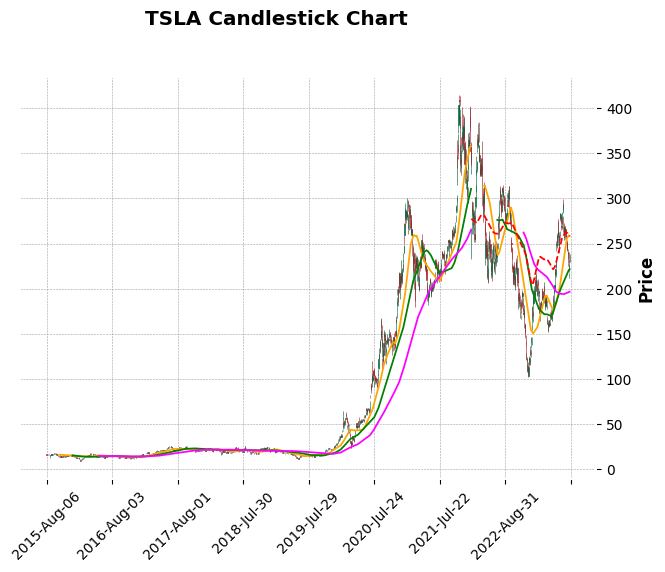

In [40]:
# Truncate or slice test_df to match the length of predicted_prices
truncated_test_data = test_data.iloc[-len(predicted_prices):]
plot_candlestick_full(train_data,truncated_test_data, predicted_prices)